In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

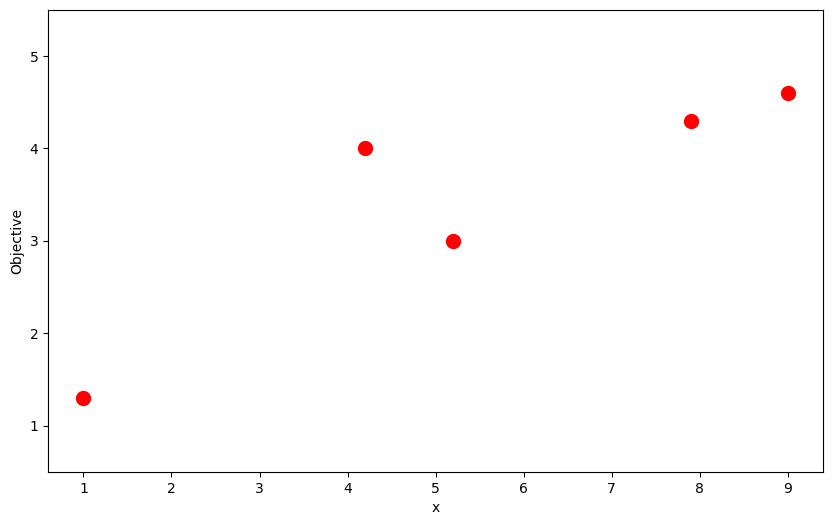

In [64]:
# 3 observations of a single parameter (x) and their corresponding output (y)
X = np.array([[1], [4.2], [5.2], [7.9], [9]])  # 1D input data (shape is (n_samples, 1))
y = np.array([1.3, 4, 3, 4.3, 4.6])  # Observations (outputs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the original observations
plt.scatter(X, y, c='r', s=100, zorder=10)

plt.ylim((0.5, 5.5))

plt.xlabel('x')
plt.ylabel('Objective')
plt.savefig('../_assets/bayesopt_demo_points.png', bbox_inches='tight')
plt.show()

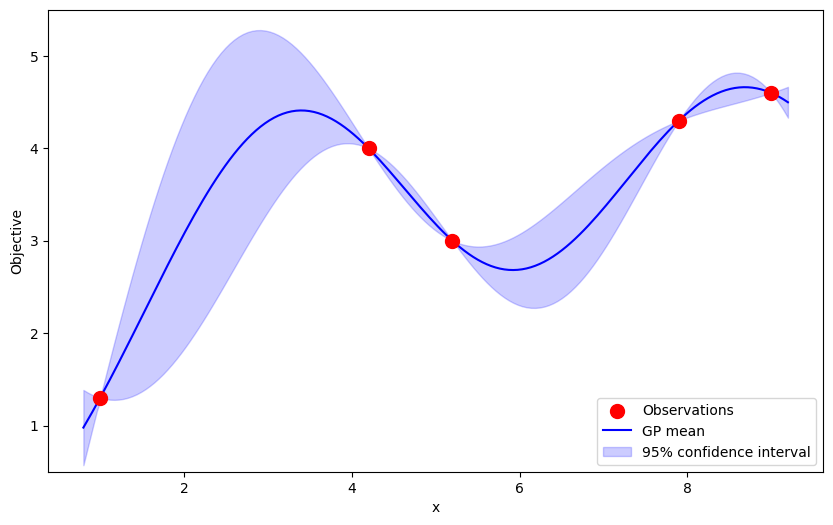

In [65]:
# Define the kernel for the GP: constant kernel times RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Create a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model to the data
gp.fit(X, y)

# Generate test data for prediction (over a grid of points for visualization)
X_test = np.linspace(0.8, 9.2, 160).reshape(-1, 1)  # Input space for predictions

# Predict using the GP model
y_pred, sigma = gp.predict(X_test, return_std=True)  # Get both mean and uncertainty (std)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the original observations
plt.scatter(X, y, c='r', s=100, zorder=10, label='Observations')

# Plot the mean prediction
plt.plot(X_test, y_pred, 'b-', label='GP mean')

# Plot the uncertainty (confidence interval)
plt.fill_between(X_test.ravel(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 alpha=0.2, color='blue', label='95% confidence interval')

plt.ylim((0.5, 5.5))

plt.xlabel('x')
plt.ylabel('Objective')
plt.legend()
plt.savefig('../_assets/bayesopt_demo_gp.png', bbox_inches='tight')
plt.show()

In [58]:
def expected_improvement(X, Y_sample, gp, xi=0.01):
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

ei = expected_improvement(X_test, y, gp)

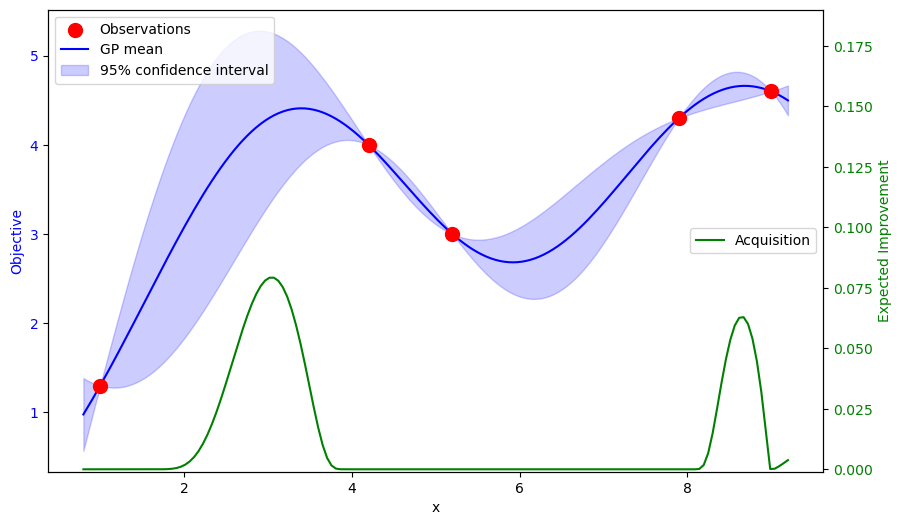

In [67]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the original observations
ax1.scatter(X, y, c='r', s=100, zorder=10, label='Observations')

# Plot the GP mean prediction
ax1.plot(X_test, y_pred, 'b-', label='GP mean')

# Plot the uncertainty (confidence interval)
ax1.fill_between(X_test.ravel(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 alpha=0.2, color='blue', label='95% confidence interval')

ax1.set_xlabel('x')
ax1.set_ylabel('Objective', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.set_ylim(-0.001, 0.19)

ax2.plot(X_test, ei, 'g-', label='Acquisition')

ax2.set_ylabel('Expected Improvement', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.legend(loc='upper left')
ax2.legend(loc='right')
plt.savefig('../_assets/bayesopt_demo_acq.png', bbox_inches='tight')
plt.show()